# CS5489 - Machine Learning
# Lecture 4c - Classification Summary
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Nonlinear classifiers
2. Kernel trick and kernel SVM
3. Ensemble Methods - Boosting, Random Forests
4. **Classification Summary**

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

In [2]:
def drawstump(fdim, fthresh, fdir='gt', poscol=None, negcol=None, lw=2, ls='k-'):
    # fdim = dimension
    # fthresh = threshold
    # fdir = direction (gt, lt)
    
    if fdir == 'lt':
        # swap colors
        tmp = poscol
        poscol = negcol
        negcol = tmp
    
    # assume fdim=0
    polyxn = [fthresh, fthresh, -30, -30]
    polyyn = [30, -30, -30, 30]
    
    polyxp = [fthresh, fthresh, 30, 30]
    polyyp = [30, -30, -30, 30]
        
    # fill positive half-space or neg space
    if (poscol):
        if fdim==0:
            plt.fill(polyxp, polyyp, poscol, alpha=0.2)
        else:
            plt.fill(polyyp, polyxp, poscol, alpha=0.2)            
    
    if (negcol):
        if fdim==0:
            plt.fill(polyxn, polyyn, negcol, alpha=0.2)
        else:
            plt.fill(polyyn, polyxn, negcol, alpha=0.2)

    # plot line
    if fdim==0:
        plt.plot(polyxp[0:2], polyyp[0:2], ls, lw=lw)
    else:
        plt.plot(polyyp[0:2], polyxp[0:2], ls, lw=lw)

def drawplane(w, b=None, c=None, wlabel=None, poscol=None, negcol=None, lw=2, ls='k-'):
    # w^Tx + b = 0
    # w0 x0 + w1 x1 + b = 0
    # x1 = -w0/w1 x0 - b / w1

    # OR
    # w^T (x-c) = 0 = w^Tx - w^Tc  --> b = -w^Tc
    if c != None:
        b = -sum(w*c)
    
    # the line
    if (abs(w[0])>abs(w[1])):   # vertical line
        x0 = array([-30,30])
        x1 = -w[0]/w[1] * x0 - b / w[1]
    else:                       # horizontal line
        x1 = array([-30,30])
        x0 = -w[1]/w[0] * x1 - b / w[0]
    
    # fill positive half-space or neg space
    if (poscol):
        polyx = [x0[0], x0[-1], x0[-1], x0[0]]
        polyy = [x1[0], x1[-1], x1[0], x1[0]]
        plt.fill(polyx, polyy, poscol, alpha=0.2)
    
    if (negcol):
        polyx = [x0[0], x0[-1], x0[0], x0[0]]
        polyy = [x1[0], x1[-1], x1[-1], x1[0]]
        plt.fill(polyx, polyy, negcol, alpha=0.2)
        
    # plot line
    lineplt, = plt.plot(x0, x1, ls, lw=lw)

    # the w
    if (wlabel):
        xp = array([0, -b/w[1]])
        xpw = xp+w
        plt.arrow(xp[0], xp[1], w[0], w[1], width=0.01)
        plt.text(xpw[0]-0.5, xpw[1], wlabel)
    return lineplt

In [3]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris2.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (versicolor=1, virginica=2)

print(X.shape)

# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.5, test_size=0.5, random_state=4487)

print(trainX.shape)
print(testX.shape)

(100, 2)
(50, 2)
(50, 2)


In [4]:
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

axbox = [2.5, 7, 1.5, 4]



# Feature Pre-processing
- Some classifiers, such as SVM and LR, are sensitive to the scale of the feature values.
  - feature dimensions with larger values may dominate the objective function.
- Common practice is to _standardize_ or _normalize_ each feature dimension before learning the classifier.
  - Two Methods...

- **Method 1:** scale each feature dimension so the mean is 0 and variance is 1.
    - $\tilde{x}_d = \frac{1}{s}(x_d-m)$
    - $s$ is the standard deviation of feature values.
    - $m$ is the mean of the feature values.
- **NOTE:** the parameters for scaling the features should be estimated from the training set!
  - same scaling is applied to the test set.

In [5]:
# using the iris data
scaler = preprocessing.StandardScaler()  # make scaling object
trainXn = scaler.fit_transform(trainX)   # use training data to fit scaling parameters
testXn  = scaler.transform(testX)        # apply scaling to test data

In [6]:
nfig1 = plt.figure(figsize=(9,4))
axbox2 = [-3, 3, -3, 3]

plt.subplot(1,2,1)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.axis(axbox); plt.grid(True)
plt.axis('equal')
plt.title("unnormalized features")

plt.subplot(1,2,2)
plt.scatter(trainXn[:,0], trainXn[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.axis(axbox2); plt.grid(True)
plt.axis('equal')
plt.title("normalized features")
plt.close()

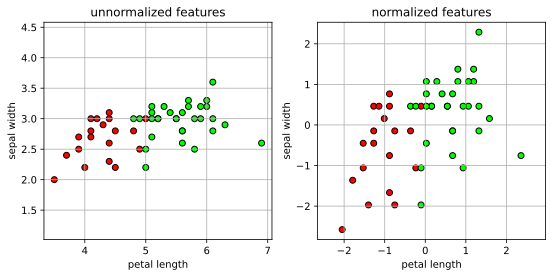

In [7]:
nfig1

- **Method 2:** scale features to a fixed range, -1 to 1.
  - $\tilde{x}_d = 2*(x_d - min) / (max-min) - 1$
  - $max$ and $min$ are the maximum and minimum features values.



In [8]:
# using the iris data
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXn = scaler.fit_transform(trainX)   # use training data to fit scaling parameters
testXn  = scaler.transform(testX)        # apply scaling to test data

In [9]:
nfig2 = plt.figure(figsize=(9,4))
axbox2 = [-1, 1, -1, 1]

plt.subplot(1,2,1)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')

plt.axis(axbox); plt.grid(True)
plt.axis('equal')
plt.title("unnormalized features")

plt.subplot(1,2,2)
plt.scatter(trainXn[:,0], trainXn[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.axis(axbox2); plt.grid(True)
plt.axis('equal')
plt.title("normalized features [-1,1]")
plt.close()

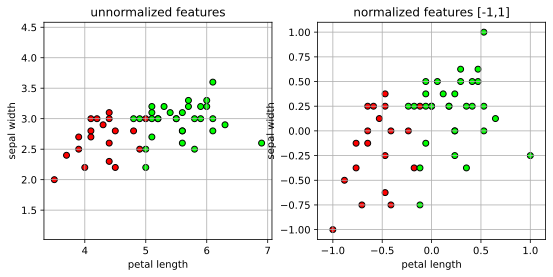

In [10]:
nfig2

# Data Representation and Feature Engineering
- How to represent data as a vector of numbers?
  - the encoding of the data into a feature vector should make sense
  - inner-products or distances calculated between feature vectors should be meaningful in terms of the data.

- Categorical variables
  - Example: $x$ has 3 possible category labels: cat, dog, horse
  - We could encode this as: $x=0$, $x=1$, and $x=2$.
    - Suppose we have two data points: $x = cat$, $x'=horse$.
    - What is the meaning of $x*x' = 2$?

# One-hot encoding
- encode a categorical variable as a vector of ones and zeros
  - if there are $K$ categories, then the vector is $K$ dimensions.
- Example:
  - x=cat $\rightarrow$ x=[1 0 0]
  - x=dog $\rightarrow$ x=[0 1 0]
  - x=horse $\rightarrow$ x=[0 0 1]

In [30]:
# one-hot encoding example
X = [['cat'], ['dog'], ['cat'], ['bird'], ['dog']]  # each row is a sample
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(X)         # map the categories to one-hot vectors
print(ohe.categories_)
ohe.transform(X)   # transform to one-hot-encoding

[array(['bird', 'cat', 'dog'], dtype=object)]


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

# Binning
- encode a real value as a vector of ones and zeros
  - assign each feature value to a bin, and then use one-hot-encoding

In [40]:
# example
X = [[-3], [0.5], [1.5], [2.5]]  # the data
bins = [-2,-1,0,1,2]      # define the bin edges

# map from value to bin number
Xbins = digitize(X, bins=bins)   

# map from bin number (0..5) to 0-1 vector
ohe = preprocessing.OneHotEncoder(categories=[arange(6)], sparse=False)
ohe.fit(Xbins)
ohe.transform(Xbins)

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

# Data transformations - polynomials
- Represent interactions between features using polynomials
- Example:
  - 2nd-degree polynomial models pair-wise interactions
    - $[x_1, x_2] \rightarrow [x_1^2, x_1 x_2, x_2^2]$
  - Combine with other degrees:
    - $[x_1, x_2] \rightarrow [1, x_1, x_2, x_1^2, x_1 x_2, x_2^2]$

In [41]:
X = [[0,1], [1,2], [3,4]]
pf = preprocessing.PolynomialFeatures(degree=2)
pf.fit(X)
pf.transform(X) 

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  1.,  2.,  1.,  2.,  4.],
       [ 1.,  3.,  4.,  9., 12., 16.]])

# Data transformations - univariate
- Apply a non-linear transformation to the feature
  - e.g., x $\rightarrow$ log(x)
  - useful if the dynamic range of x is very large

# Unbalanced Data
- For some classification tasks that data will be unbalanced
  - many more examples in one class than the other.
- **Example:** detecting credit card fraud
  - credit card fraud is rare
    - 50 examples of fraud, 5000 examples of legitimate transactions.

In [43]:
# generate random data
X,Y = datasets.make_blobs(n_samples=200, 
         centers=[[0,0]], cluster_std=2, n_features=2, random_state=4487)
X2,Y2 = datasets.make_blobs(n_samples=20, 
         centers=[[3,3]], cluster_std=0.5, n_features=2, random_state=4487)

X = r_[X,X2]
Y = r_[Y,Y2+1]

udatafig = plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y,cmap=mycmap, edgecolors='k')
plt.grid(True)
plt.title('class 0: 200 points; class 1: 20 points')
plt.close()

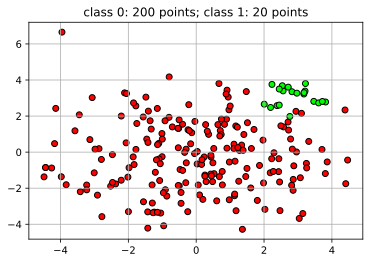

In [44]:
udatafig

- Unbalanced data can cause problems when training the classifier
  - classifier will focus more on the class with more points.
  - decision boundary is pushed away from  class with more points

In [45]:
clf = svm.SVC(kernel='linear', C=10)
clf.fit(X, Y)

udatafig1 = plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y,cmap=mycmap, edgecolors='k')

w = clf.coef_[0]
b = clf.intercept_[0]
l1 = drawplane(w, b, lw=2, ls='k-')
plt.legend((l1,), ('SVM decision boundary',), fontsize=9)
plt.axis([-6, 7, -6, 7])
plt.grid(True)
plt.close()

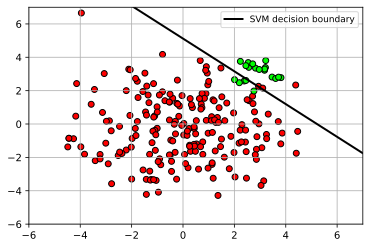

In [46]:
udatafig1

- **Solution:** apply weights on the classes during training.
  - weights are inversely proportional to the class size.

In [47]:
clfw = svm.SVC(kernel='linear', C=10,  class_weight='balanced')
clfw.fit(X, Y)

print("class weights =", clfw.class_weight_)

class weights = [0.55 5.5 ]


In [48]:
udatafig2 = plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y,cmap=mycmap, edgecolors='k')

w = clf.coef_[0]
b = clf.intercept_[0]
ww = clfw.coef_[0]
bw = clfw.intercept_[0]
l1 = drawplane(w, b, lw=2, ls='k--')
l2 = drawplane(ww, bw, lw=2, ls='k-')
plt.legend((l1,l2), ('unweighted', 'weighted'), fontsize=9)
plt.axis([-6, 7, -6, 7])
plt.grid(True)
plt.close()

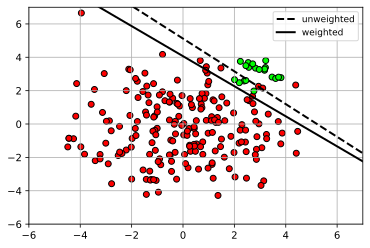

In [49]:
udatafig2

# Classifier Imbalance
- In some tasks, errors on certain classes cannot be tolerated.
- **Example:** detecting spam vs non-spam
  - non-spam should _definitely not_ be marked as spam
    - okay to mark some spam as non-spam

In [51]:
X,Y = datasets.make_blobs(n_samples=200, 
         centers=[[-3,0],[3,0]], cluster_std=2, n_features=2, random_state=447)
udatafig3 = plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
plt.grid(True)
plt.close()

clf = svm.SVC(kernel='linear', C=10)
clf.fit(X, Y)

SVC(C=10, kernel='linear')

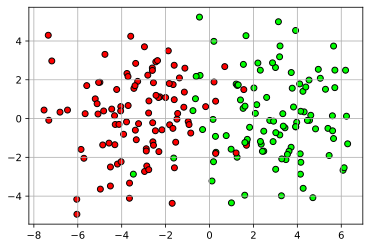

In [52]:
udatafig3

...

- Class weighting can be used to make the classifier focus on certain classes
  - e.g., weight non-spam class higher than spam class
    - classifier will try to correctly classify all non-spam samples, at the expense of making errors on spam samples.

In [53]:
# dictionary (key,value) = (class name, class weight)
cw = {0: 0.2, 
      1:  5}  # class 1 is 25 times more important!

clfw = svm.SVC(kernel='linear', C=10,  class_weight=cw)
clfw.fit(X, Y);

In [54]:
udatafig4 = plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
plt.grid(True)

w = clf.coef_[0]
b = clf.intercept_[0]
ww = clfw.coef_[0]
bw = clfw.intercept_[0]
l1 = drawplane(w, b, lw=2, ls='k--')
l2 = drawplane(ww, bw, lw=2, ls='k-')
plt.legend((l1,l2), ('unweighted', 'weighted'), fontsize=9)
plt.axis([-10, 8, -6, 6])

plt.close()

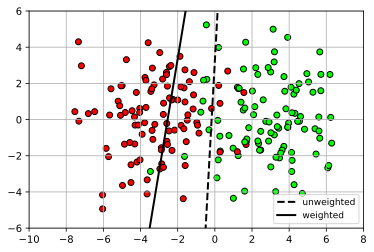

In [55]:
udatafig4

 ...

# Classification Summary

- **Classification task**
  - Observation $\mathbf{x}$: typically a real vector of feature values, $\mathbf{x}\in\mathbb{R}^d$.
  - Class $y$: from a set of possible classes, e.g., ${\cal Y} = \{0,1\}$
  - **Goal:** given an observation $\mathbf{x}$, predict its class $y$.
    
<table style="font-size:9pt;">
<tr>
<th>Name</th>
<th>Type</th>
<th>Classes</th>
<th>Decision function</th>
<th>Training</th>
<th>Advantages</th>
<th>Disadvantages</th>
</tr>
<tr>
<td>Bayes' classifier</td>
<td>generative</td>
<td>multi-class</td>
<td>non-linear</td>
<td>estimate class-conditional densities $p(x|y)$ by maximizing likelihood of data.</td>
<td>- works well with small amounts of data.<br>- multi-class.<br>- minimum probability of error if probability models are correct.</td>
<td>- depends on the data correctly fitting the class-conditional.</td>
</tr>
<tr>
<td>logistic regression</td>
<td>discriminative</td>
<td>binary</td>
<td>linear</td>
<td>maximize likelihood of data in $p(y|x)$.</td>
<td>- well-calibrated probabilities.<br>- efficient to learn.</td>
<td>- linear decision boundary.<br>- sensitive to $C$ parameter.</td>
</tr>
<tr>
<td>support vector machine (SVM)</td>
<td>discriminative</td>
<td>binary</td>
<td>linear</td>
<td>maximize the margin (distance between decision surface and closest point).</td>
<td>- works well in high-dimension.<br>- good generalization.</td>
<td>- linear decision boundary.<br>- sensitive to $C$ parameter.</td>
</tr>
<tr>
<td>kernel SVM</td>
<td>discriminative</td>
<td>binary</td>
<td>non-linear (kernel function)</td>
<td>maximize the margin.</td>
<td>- non-linear decision boundary.<br>- can be applied to non-vector data using appropriate kernel.</td>
<td>- sensitive to kernel function and hyperparameters.<br>
- high memory usage for large datasets</td>
</tr>
<tr>
<td>AdaBoost</td>
<td>discriminative</td>
<td>binary</td>
<td>non-linear (ensemble of weak learners)</td>
<td>train successive weak learners to focus on misclassified points.</td>
<td>- non-linear decision boundary. can do feature selection.<br>- good generalization.</td>
<td>- sensitive to outliers.</td>
</tr>
<tr>
<td>XGBoost</td>
<td>discriminative</td>
<td>binary</td>
<td>non-linear (ensemble of decision trees)</td>
<td>train successive learners to focus on gradient of the loss.</td>
<td>- non-linear decision boundary.<br>- good generalization.</td>
<td>- sensitive to outliers.</td>
</tr>
<tr>
<td>Random Forest</td>
<td>discriminative</td>
<td>multi-class</td>
<td>non-linear (ensemble of decision trees)</td>
<td>aggregate predictions over several decision trees, trained using different subsets of data.</td>
<td>- non-linear decision boundary. can do feature selection.<br>- good generalization.<br>- fast</td>
<td>- sensitive to outliers.</td>
</tr>
</table>

# Loss functions
- The classifiers differ in their loss functions, which influence how they work.
  - $z_i = y_i f(\mathbf{x}_i)$

In [56]:
z = linspace(-6,6,100)
logloss = log(1+exp(-z)) / log(2)
hingeloss = maximum(0, 1-z)
exploss = exp(-z)
lossfig = plt.figure()

plt.plot([0,0], [0,9], 'k--')
plt.text(0,8.5, "incorrectly classified $\\Leftarrow$ ", ha='right', weight='bold')
plt.text(0,8.5, " $\Rightarrow$ correctly classified", ha='left', weight='bold')

plt.plot(z,hingeloss, 'b-', label='hinge (SVM)')
plt.plot(z,logloss, 'r-', label='logistic (LR)')
plt.plot(z,exploss, 'g-', label='exponential (AdaBoost)')
plt.axis([-6,6,0,9]); plt.grid(True)
plt.xlabel('$z_i$');
plt.ylabel('loss')
plt.legend(loc='right', fontsize=10)
plt.title('loss functions')
plt.close()

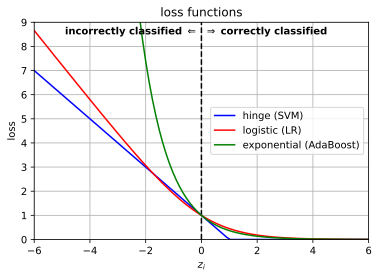

In [57]:
lossfig

# Regularization and Overfitting
- Some models have terms to prevent overfitting the training data.
  - this can improve _generalization_ to new data.
- There is a parameter to control the regularization effect.
  - select this parameter using cross-validation on the training set.

In [59]:
X,Y = datasets.make_blobs(n_samples=100, 
         centers=[[-3,0],[3,0]], cluster_std=1.5, n_features=2, random_state=447)
udatafig3 = plt.figure()
axbox = [-10,8,-6,6]
xr = [linspace(axbox[0], axbox[1], 50), linspace(axbox[2], axbox[3], 50)]

Cs = [0.1, 10, 100]
clf={}

ofig = plt.figure(figsize=(9,3))
for i,C in enumerate(Cs):
    clf[C] = svm.SVC(kernel='rbf', C=C, gamma=0.05)
    clf[C].fit(X, Y)
    
    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    score = clf[C].decision_function(allpts).reshape(xgrid0.shape)

    cmap = ([1,0,0], [1,0.7,0.7], [0.7,1,0.7], [0,1,0])
    
    plt.subplot(1,len(Cs),i+1)
    plt.contourf(xr[0], xr[1], score, colors=cmap, 
             levels=[-1000, -1, 0, 1, 1000], alpha=0.3)
    plt.contour(xr[0], xr[1], score, levels=[-1, 1], linewidths=1, linestyles='dashed', colors='k')
    plt.contour(xr[0], xr[1], score, levels=[0], linestyles='solid', colors='k')

    plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
    
    #plt.plot(clf.support_vectors_[:,0], clf.support_vectors_[:,1],
    #         'ko',fillstyle='none', markeredgewidth=2)
    plt.axis(axbox); plt.grid(True)
    plt.title('C='+str(C))
plt.close()

<Figure size 432x288 with 0 Axes>

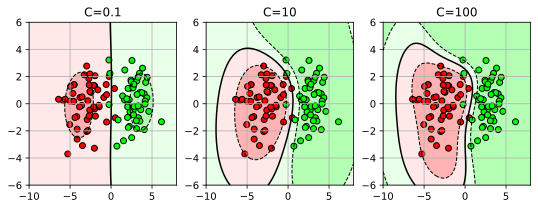

In [60]:
ofig

# Structural Risk Minimization
- A general framework for balancing data fit and model complexity.
- Many learning problems can be written as a combination of data-fit and regularization term:
$$f^* = \mathop{\mathrm{argmin}}_{f} \sum_i L(y_i, f(\mathbf{x}_i)) + \lambda \Omega(f)$$
  - assume $f$ within some class of funcitions, e.g., linear functions $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+b$.
  - $L$ is the loss function, e.g., logistic loss.
  - $\Omega$ is the regularization function on $f$, e.g., $||\mathbf{w}||^2$
  - $\lambda$ is the tradeoff parameter, e.g., $1/C$.


# Other things
- *Multiclass classification*
  - can use binary classifiers to do multi-class using _1-vs-rest_ formulation.
- *Feature normalization*
  - normalize each feature dimension so that some feature dimensions with larger ranges do not dominate the optimization process.
- *Unbalanced data*
  - if more data in one class, then apply weights to each class to balance objectives.
- *Class imbalance*
  - mistakes on some classes are more critical.
  - reweight class to focus classifier on correctly predicting one class at the expense of others.

# Applications
- Web document classification, spam classification
- Face gender recognition, face detection, digit classification

# Features
- Choice of features is important!
  - using uninformative features may confuse the classifier.
  - use domain knowledge to pick the best features to extract from the data.

# Which classifier is best?
- **"No Free Lunch" Theorem** (Wolpert and Macready)
  
> "If an algorithm performs well on a certain class of problems then it necessarily pays for that with degraded performance on the set of all remaining problems."
  
  - In other words, there is no *best* classifier for all tasks.  The best classifier depends on the particular problem.